# Minimize Hamiltonian 1d chains

### Note on shapes
Tensors flowing in the network represent batches of states of a dynamical system. Similarly to what is done for images, audio or other signals in deep learning, we distinguish a physical from a hidden or internal dimension. In images, these are the spatial and channel dimension, where the latter encodes features represeting abstract concept of the input space. Therefore, tensors will have shape (batches, phase_space, internal). While the physical system has internal dimension = 1, we will use convolutional layers which treat differently the phase space from the internal or channel dimension, and so we separate these dimensions from the beginning and use convolutions to extract features characterizing the physical systems and which will increase the internal dimension. Here we study 1d, where phase_space dimension equals twice the number of particles.

In particular, we take the following basis of R^2n: (q1,p1,q2,p2,...,qn,pn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.enable_eager_execution()

In [2]:
from hamiltonians import fpu_beta_hamiltonian
from models import NICE, SymplecticExchange, SqueezeAndShift, Chain
from models import MLP, MultiScaleArchitecture, CNNShiftModel, CNNShiftModel2
from utils import visualize_chain_bijector_1d, compute_loss, compute_gradients, apply_gradients

In [3]:
tf.set_random_seed(0)

In [4]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [5]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': fpu_beta_hamiltonian, 
    'num_scales' : 1,     # num scales architecture        
    'phase_space_dim': 4, # Need phase_space_dim at least 2**num_scales. Also, = 2 * num_particles for chains.
    'batch_size': 128,    # Mini batch size 
    'num_steps_flow': 4, # num bijector per step of flow
    'train_iters': int(1e4)}   # Number of training iterations

Base distribution

In [6]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([settings['phase_space_dim']], DTYPE))

## Create architecture for model parameters

In [7]:
flows = []
for i in range(settings['num_scales']):
    bijectors = [SqueezeAndShift(shift_model=CNNShiftModel2()) if i % 2 == 0 
             else SymplecticExchange() 
             for i in range(settings['num_steps_flow'])]
    flows.append(Chain(bijectors))
model = MultiScaleArchitecture(flows)

## Optimize loss

In [8]:
import time
start_time = time.time()

optimizer = tf.train.AdamOptimizer(1e-4)

global_step = []
losses = []
for epoch in range(settings['train_iters']):
    z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
    gradients, loss = compute_gradients(model, settings['hamiltonian'], z_samples)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    # Visualization
    if epoch % 1e2 == 0:
        global_step.append(epoch)
        losses.append(loss.numpy())
    if epoch % int(1e3) == 0:
        print(epoch, loss.numpy())
end_time = time.time()
print("Time elapsed: ", end_time - start_time)

0 11.619413
1000 5.0363193
2000 4.5232186
3000 4.7869477
4000 3.8763518
5000 4.250903
6000 4.588816
7000 3.5239651
8000 3.8587942
9000 3.967547
Time elapsed:  428.8640191555023


### Plot loss

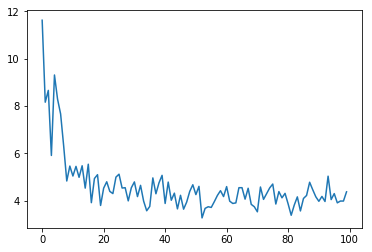

In [9]:
start = 0
plt.plot(losses[start:])

In [11]:
# Save:
from utils import checkpoint_save
checkpoint_save(settings, optimizer, model,
                tf.train.get_or_create_global_step())    

In [23]:
# Restore:
# checkpoint_restore(settings, optimizer, model, optimizer_step)

In [12]:
# Test accuracy
z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
test_error = compute_loss(model, settings['hamiltonian'], z_samples)
print("Test error: ", test_error)

Test error:  tf.Tensor(4.1952133, shape=(), dtype=float32)


### Test symmetries
Lattice shift means that the learnt prob distribution is invariant under shifts. Symplecticity, check relation with symplectic form.

In [13]:
# Test lattice shift symmetry
from utils import lattice_shift

x = tf.random_normal((1,settings['phase_space_dim'],1), dtype=DTYPE) # q_1, p_1, q_2, p_2
z = tf.reshape(model.inverse(x), shape=[settings['phase_space_dim']])
x_shifted = lattice_shift(x) # q_2, p_2, q_1, p_1
z_shifted = tf.reshape(model.inverse(x_shifted), shape=[settings['phase_space_dim']])
print(base_dist.log_prob(z) - base_dist.log_prob(z_shifted))

tf.Tensor(0.0, shape=(), dtype=float32)


In [14]:
# Test symplecticity
from utils import is_symplectic

x = tf.random_normal((1,settings['phase_space_dim'],1), dtype=DTYPE)
is_symplectic(model, x)

True

## Conclusions

The model is symplectic and the learnt distribution is lattice shift invariant as required for a chain. While the multi-scale architecture is by design symplectic as well, lattice invariance is harder to achieve in that case and longer training is required.

## Flow of the system
TODO